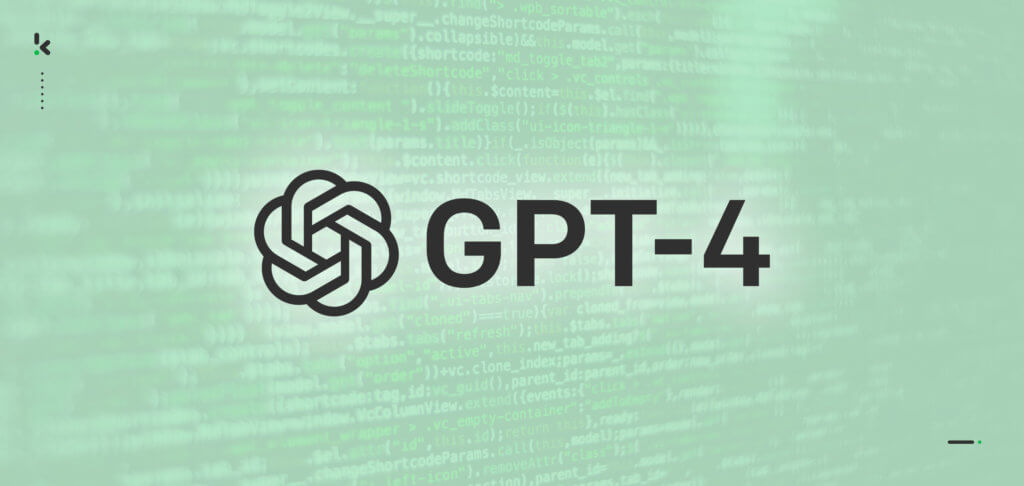

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()


import re
import string 

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm

In [2]:
df=pd.read_csv(r'C:\Users\prave\Downloads\tweets.csv')
df.head()

date  \
0  2023-03-28 23:05:36+00:00   
1  2023-03-28 23:05:00+00:00   
2  2023-03-28 23:04:54+00:00   
3  2023-03-28 23:04:44+00:00   
4  2023-03-28 23:04:26+00:00   

                                                text  user_name user_location  \
0  #GPT4 saved dog's life. Ape #GPT4 will save yo...  😄Kenneth😅           NaN   
1  #ChatGPT can triple productivity.🦾🧠 Are you re...     Brian😜           NaN   
2  #GPT4 saved dog's life. Ape #GPT4 will save yo...       Paul           NaN   
3  GM!☕️☀️ \nJust aped 3 eth in #GPT4 and it is p...   😂Edward🎃           NaN   
4  If you haven't #hodl any #GPT4, then you may m...   🤩Kenneth           NaN   

  user_description               user_created  user_followers  user_friends  \
0              NaN  2013-11-08 20:41:28+00:00              50           456   
1              NaN  2014-08-25 16:15:39+00:00               1             0   
2              NaN  2014-12-29 14:20:03+00:00               4             0   
3              NaN  2013-08-16 11:53:20+00:00               3            47   
4              NaN  2014-08-30 17:09:08+00:00               0             1   

   user_favourites  user_verified                             hashtags  \
0                5          False             ['GPT4', 'GPT4', 'GPT4']   
1                0          False  ['ChatGPT', 'AI', 'Crypto', 'GPT4']   
2                0          False             ['GPT4', 'GPT4', 'GPT4']   
3                9          False      ['GPT4', 'HODL', 'GPT4', 'ATH']   
4                0          False     ['hodl', 'GPT4', 'web3', 'GPT4']   

            source  
0  Twitter Web App  
1  Twitter Web App  
2  Twitter Web App  
3  Twitter Web App  
4  Twitter Web App

In [3]:
print('Rows              :',df.shape[0])
print('Columns           :',df.shape[1])
print('\nFeatures        :\n',df.columns.tolist())
print('\nMissing values  :',df.isna().sum().values.sum())
print('\nUnique values   :',df.nunique())

Rows              : 20048
Columns           : 12

Features        :
 ['date', 'text', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'hashtags', 'source']

Missing values  : 20773

Unique values   : date                19293
text                19965
user_name            8125
user_location        2890
user_description     7736
user_created         8171
user_followers       3217
user_friends         2691
user_favourites      5026
user_verified           2
hashtags             3480
source                116
dtype: int64


### Here new feature "sentiment" is created. corresponding to each tweet text.

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyser=SentimentIntensityAnalyzer()
scores=[]
for i in range(len(df['text'])):
    score=analyser.polarity_scores(df['text'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment']=pd.Series(np.array(sentiment))

In [5]:
df.head(3)

date  \
0  2023-03-28 23:05:36+00:00   
1  2023-03-28 23:05:00+00:00   
2  2023-03-28 23:04:54+00:00   

                                                text  user_name user_location  \
0  #GPT4 saved dog's life. Ape #GPT4 will save yo...  😄Kenneth😅           NaN   
1  #ChatGPT can triple productivity.🦾🧠 Are you re...     Brian😜           NaN   
2  #GPT4 saved dog's life. Ape #GPT4 will save yo...       Paul           NaN   

  user_description               user_created  user_followers  user_friends  \
0              NaN  2013-11-08 20:41:28+00:00              50           456   
1              NaN  2014-08-25 16:15:39+00:00               1             0   
2              NaN  2014-12-29 14:20:03+00:00               4             0   

   user_favourites  user_verified                             hashtags  \
0                5          False             ['GPT4', 'GPT4', 'GPT4']   
1                0          False  ['ChatGPT', 'AI', 'Crypto', 'GPT4']   
2                0          False             ['GPT4', 'GPT4', 'GPT4']   

            source sentiment  
0  Twitter Web App  Positive  
1  Twitter Web App  Positive  
2  Twitter Web App  Positive

# Exploratory Data Analysis (EDA) 

In [6]:
# Sentiment count
temp=df.groupby('sentiment')['text'].count().reset_index().sort_values(by='sentiment',ascending=False)
temp.style.background_gradient(cmap='Blues')

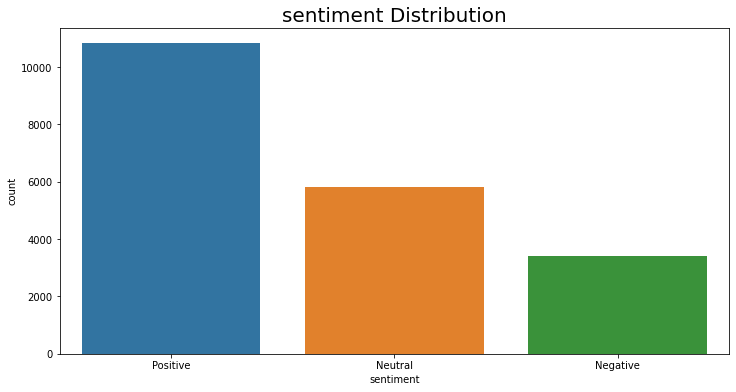

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(df['sentiment'])
plt.title('sentiment Distribution',fontsize=20)
plt.show()

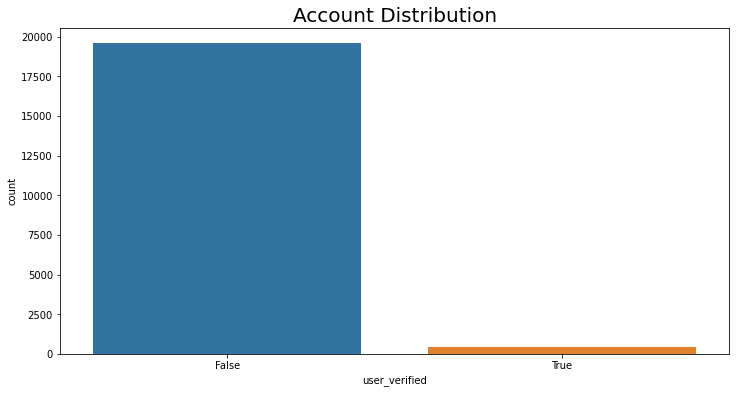

In [8]:
# Account Verified / Not verified

plt.figure(figsize=(12,6))
sns.countplot(df['user_verified'])
plt.title('Account Distribution',fontsize=20)
plt.show()

### Distribution of the favoutires recieved based on tweets sentiment and whether the account is verified/Not

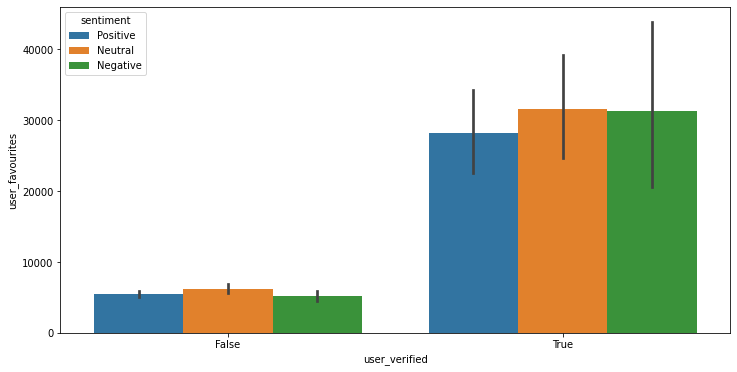

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(x='user_verified',y='user_favourites',hue='sentiment',data=df)
plt.show()

### The Top 30 Most Hashtags in the tweet text data

In [10]:
df['hashtags']=df['hashtags'].fillna('[]')

all_hashtags=[]
for i in range(len(df['hashtags'])):
    a=df['hashtags'][i].strip('][').split(',')
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No hashtags' if x=='' else x for x in all_hashtags]

all_hashtags=pd.Series(np.array(all_hashtags))
print('There are {} instances of tweets in which No hashtags were used'.format(all_hashtags.value_counts()[1]))

common_hashtags=all_hashtags.value_counts().drop(labels='No hashtags')[:30].rename_axis('Common Hashtags').reset_index(name='count')
fig=px.treemap(common_hashtags,path=['Common Hashtags'],values='count',title='Top 30 Common Hashtags')
fig.show()

There are 6160 instances of tweets in which No hashtags were used


### Sentiment wise analysis of hashtags and words

In [11]:
positive_tweet=df[df['sentiment']=='Positive'].reset_index()
negative_tweet=df[df['sentiment']=='Negative'].reset_index()
neutral_tweet=df[df['sentiment']=='Neutral'].reset_index()

In [12]:
# POSITIVE TWEETS
all_positive_words=[]
all_positive_hashtags=[]
for i in range(len(positive_tweet['text'])):
    a=positive_tweet['text'][i]
    b=positive_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_positive_words.append(i)
    for i in b:
        all_positive_hashtags.append(i)

all_positive_words=pd.Series(np.array(all_positive_words))
all_positive_hashtags=pd.Series(np.array(all_positive_hashtags))

In [13]:
all_negative_words=[]
all_negative_hashtags=[]
for i in range(len(negative_tweet['text'])):
    a=negative_tweet['text'][i]
    b=negative_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_negative_words.append(i)
    for i in b:
        all_negative_hashtags.append(i)
all_negative_words=pd.Series(np.array(all_negative_words))
all_negative_hashtags=pd.Series(np.array(all_negative_hashtags))

In [14]:
all_neutral_words=[]
all_neutral_hashtags=[]
for i in range(len(neutral_tweet['text'])):
    a=neutral_tweet['text'][i]
    b=neutral_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_neutral_words.append(i)
    for i in b:
        all_neutral_hashtags.append(i)
all_neutral_words=pd.Series(np.array(all_neutral_words))
all_neutral_hashtags=pd.Series(np.array(all_neutral_hashtags))

In [15]:
common=set(all_positive_words).intersection(set(all_negative_words)).intersection(set(all_neutral_words))
common_list=list(common)

common_words=all_negative_words.value_counts().drop(labels=common_list)[:30].rename_axis('common negative words').reset_index(name='count')
fig=px.treemap(common_words,path=['common negative words'],values='count',title='Top 30 Unique words in negative Tweets')
fig.show()

common_words=all_positive_words.value_counts().drop(labels=common_list)[:30].rename_axis('common positive words').reset_index(name='count')
fig=px.treemap(common_words,path=['common positive words'],values='count',title='TOp 30 Unique words in Positive Tweets')
fig.show()

common_words=all_neutral_words.value_counts().drop(labels=common_list)[:30].rename_axis('common neutral words').reset_index(name='count')
fig=px.treemap(common_words,path=['common neutral words'],values='count',title='Top 30 Unique words in neutral Tweets')
fig.show()

### Source Distribution of Tweets

In [16]:
data_=df['source'].value_counts().reset_index()

trace1=go.Bar(x=['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android','LinkedIn', 'HubSpot', 'IFTTT', 
                 'Hypefury', 'Sprout Social','Revive Social App', 'Buffer'],
              y=data_['source'],marker=dict(color='rgb(250,13,92)',
              line=dict(color='rgb(0,0,0)',width=1.5)),text=data_['source'],textposition='outside')

layout=go.Layout(template='plotly_dark',title='Top 10 Most Source Disrtibution Of Tweets',xaxis=dict(title='Source'),
                 yaxis=dict(title='Count'),height=700)
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

### Verified Account of Tweet

In [17]:
data_verified=df[df['user_verified']==True].reset_index()
data_not_verified=df[df['user_verified']==False].reset_index()

In [18]:
data_=data_verified['source'].value_counts().reset_index()

trace1=go.Bar(x=['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android','LinkedIn', 'HubSpot', 'IFTTT', 
                 'Hypefury', 'Sprout Social','Revive Social App', 'Buffer',],y=data_['source'],
            marker=dict(color='rgb(250,13,92)',line=dict(color='rgb(0,0,0)',width=1.5)),text=data_['source'],
             textposition='outside')
layout=go.Layout(template='plotly_dark',title='Top 20 Most Source Distribution of Twwets From Verified Accounts',xaxis=dict(title='Source'),
                yaxis=dict(title='Count'),height=650)
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

In [19]:
all_hashtags=[]
for i in range(len(data_verified['hashtags'])):
    a=data_verified['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_hashtags.append(i)
all_hashtags=pd.Series(np.array(all_hashtags))
common_hashtags=all_hashtags.value_counts()[:30].rename_axis('common hashtags').reset_index(name='count')
fig=px.treemap(common_hashtags,path=['common hashtags'],values='count',title='30 Most common hashtags by Verified Accounts')
fig.show()

### Tweets Sentiment Analysis Based on Location

In [20]:
df['user_location']=df['user_location'].fillna('')

postive_tweet=df[df['sentiment']=='Positive'].reset_index()
negative_tweet=df[df['sentiment']=='Negative'].reset_index()
neutral_tweet=df[df['sentiment']=='Neutral'].reset_index()

pos_location=positive_tweet['user_location']
neg_location=negative_tweet['user_location']
neu_location=neutral_tweet['user_location']

common=set(pos_location).intersection(set(neg_location)).intersection(set(neu_location))
common_list=list(common)

common_words=neg_location.value_counts().drop(labels=common_list)[:10].rename_axis('common negative location').reset_index(name='count')
fig=px.treemap(common_words,path=['common negative location'],values='count',title='10 Top Unique negative Tweets Location')
fig.show()

common_words=pos_location.value_counts().drop(labels=common_list)[:10].rename_axis('common positive location').reset_index(name='count')
fig=px.treemap(common_words,path=['common positive location'],values='count',title='10 Top Unique positive Location')
fig.show()

common_words=neu_location.value_counts().drop(labels=common_list)[:10].rename_axis('common neutral location').reset_index(name='count')
fig=px.treemap(common_words,path=['common neutral location'],values='count',title='10 top Unique Neutral Location')
fig.show()

### Accounts with highest followers analysis based on the tweet sentiment

Text(0.5, 1.0, 'Top 10 Accounts with highest follwers whos tweets are neutral')

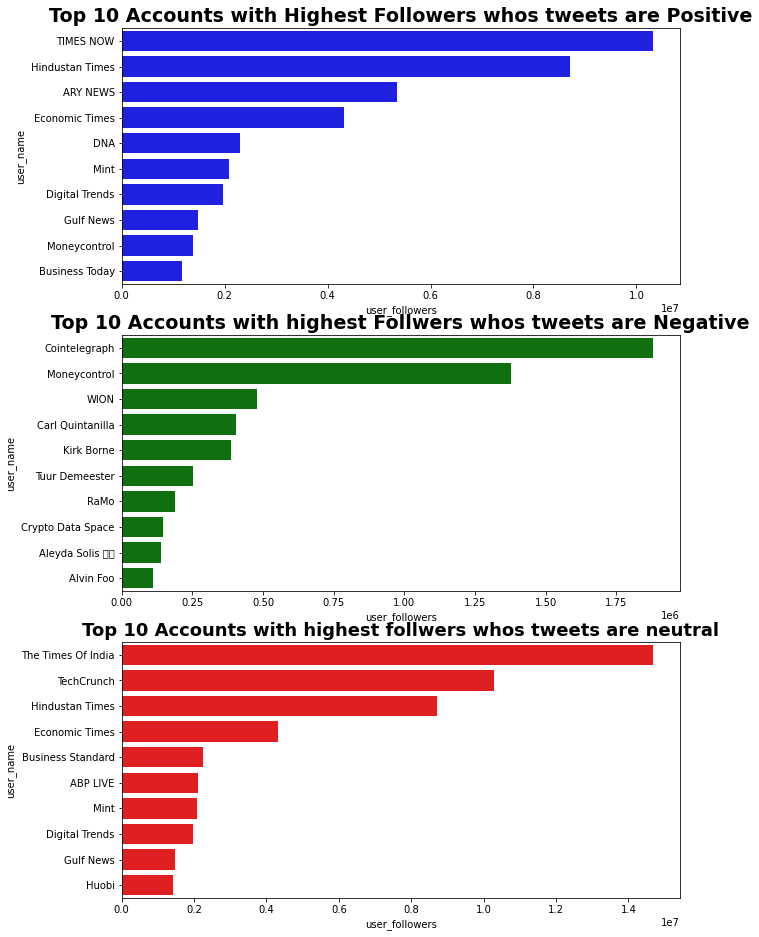

In [21]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(10,16))
sns.barplot(x='user_followers',y='user_name',orient='h',ax=ax1,palette=['b'],data=df[df['sentiment']=='Positive']\
            .drop_duplicates(subset=['user_name'])\
            .sort_values(by=['user_followers'],ascending=False)[:10])
ax1.set_title('Top 10 Accounts with Highest Followers whos tweets are Positive',fontsize=19,fontweight='bold')

sns.barplot(x='user_followers',y='user_name',orient='h',ax=ax2,palette=['g'],data=df[df['sentiment']=='Negative']\
           .drop_duplicates(subset='user_name')\
           .sort_values(by='user_followers',ascending=False)[:10])
ax2.set_title('Top 10 Accounts with highest Follwers whos tweets are Negative',fontsize=19,fontweight='bold')

sns.barplot(x='user_followers',y='user_name',orient='h',ax=ax3,palette=['r'],data=df[df['sentiment']=='Neutral']\
           .drop_duplicates(subset='user_name')\
           .sort_values(by='user_followers',ascending=False)[:10])
ax3.set_title('Top 10 Accounts with highest follwers whos tweets are neutral',fontsize=18,fontweight='bold')

### User with more friends

In [22]:
df[df['user_friends'] == df['user_friends'].max()]['user_name'].iloc[0]

'Roger James Hamilton'

### User followers in Thounds

Text(0.5, 1.0, 'Followers')

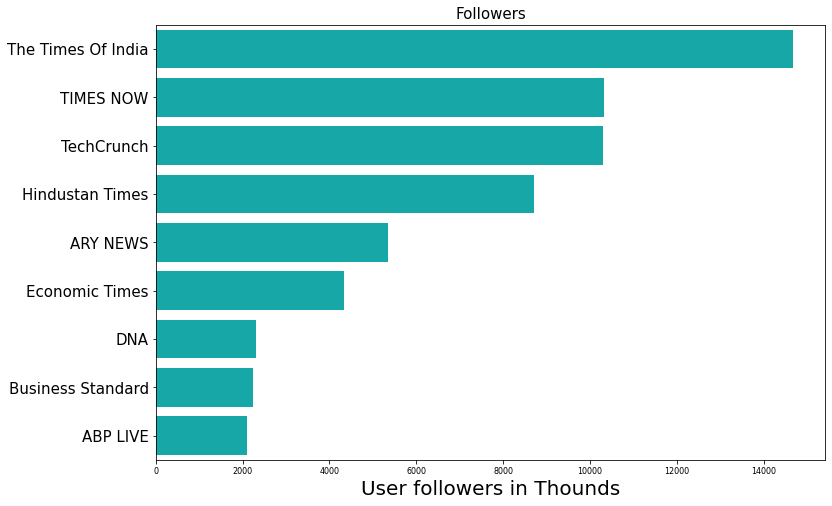

In [23]:
most_pop=df.sort_values('user_followers',ascending=False)[['user_name','user_followers']].head(12)

most_pop['user_followers1']=most_pop['user_followers']/1000


plt.figure(figsize=(12,8))

sns.barplot(data=most_pop, y='user_name',x='user_followers1',color='c')
plt.xticks(fontsize=8,rotation=0)
plt.yticks(fontsize=15,rotation=0)
plt.xlabel('User followers in Thounds',fontsize=20)
plt.ylabel('')
plt.title('Followers',fontsize=15)

# Cleaning 

In [24]:

def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)


def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)

def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    

def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)

def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   

In [25]:
df['text']=df['text'].astype(str)
df['text']=[x.replace(':',' ') for x in df['text']]

In [26]:
df['clean_text']=pd.Series([clean_text(i) for i in tqdm(df['text'])])

  0%|          | 0/20048 [00:00<?, ?it/s]

In [27]:
df.loc[:,['text','clean_text']]

text  \
0      #GPT4 saved dog's life. Ape #GPT4 will save yo...   
1      #ChatGPT can triple productivity.🦾🧠 Are you re...   
2      #GPT4 saved dog's life. Ape #GPT4 will save yo...   
3      GM!☕️☀️ \nJust aped 3 eth in #GPT4 and it is p...   
4      If you haven't #hodl any #GPT4, then you may m...   
...                                                  ...   
20043  #gpt4 also #brootswasright https //t.co/tMTUiN...   
20044  How much energy does it take to train #GPT4, t...   
20045  It looks like VIDEO is dominating the GPT-4 po...   
20046  The perfect storm is brewing, with the upcomin...   
20047  On the horizon - #GPT4 and why it matters. | T...   

                                              clean_text  
0      gpt save dog life ape gpt save life doubt gpt ...  
1      chatgpt tripl product readi enter world ai cry...  
2      gpt save dog life ape gpt save life doubt gpt ...  
3      gm ape eth gpt pump hodl gpt ath buy token uni...  
4      nt hodl gpt may miss opportun millionair web g...  
...                                                  ...  
20043        gpt also brootswasright https tcotmtuinqzcv  
20044  much energi take train gpt power languag model...  
20045  look like video domin gpt poll think gpt https...  
20046  perfect storm brew upcom gpt product launch ba...  
20047  horizon gpt matter think start inc https tcoyr...  

[20048 rows x 2 columns]

## Most discussed terms

In [28]:
words=df['clean_text'].values

In [29]:
ls=[]
for i in words:
    ls.append(str(i))

(-0.5, 1599.5, 799.5, -0.5)

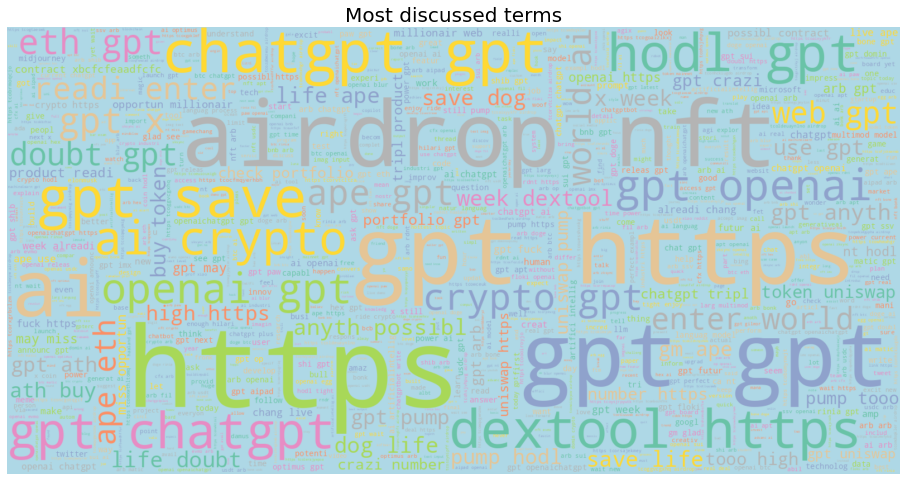

In [30]:
plt.figure(figsize=(16,13))
wc=WordCloud(background_color='lightblue',colormap='Set2',max_words=1000,max_font_size=200,width=1600,height=800)
wc.generate(" ".join(ls))
plt.title('Most discussed terms',fontsize=20)
plt.imshow(wc.recolor(colormap='Set2',random_state=17),alpha=0.98,interpolation='bilinear')
plt.axis('off')